# BEST MODEL RESNET-18

# 1.Setup

Import the required packages

In [1]:
import numpy as np
from numpy import mean

import torch.nn as nn
import torch

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import torchvision
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn

# 2.Network structure

REF：GitHub. 2021. vision/resnet.py at 6db1569c89094cf23f3bc41f79275c45e9fcb3f3 · pytorch/vision. [online] Available at: <https://github.com/pytorch/vision/blob/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models/resnet.py#L124> [Accessed 8 November 2021].

In [2]:
class BuildingBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super(BuildingBlock,self).__init__()
        self.stride=stride
        #Convolution module
        self.convPart=nn.Sequential(
            nn.Conv2d(in_channel,
                      out_channel,
                      kernel_size=3,
                      stride=stride,
                      padding=1,
                      bias=False), nn.BatchNorm2d(out_channel),
            nn.CELU(inplace=True),
            nn.Conv2d(out_channel,
                      out_channel,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(out_channel),
        )
        
        self.Residual_link = nn.Sequential()
        #Residual link
        #The step size is not 1, which means that the current block is the first layer of each stage, 
        #     and a convolution kernel with a step size of 2 is used. This will cause the number of 
        #      output channels of the convolutional layer and the number of channels of the residual link to be unequal.
        
        if stride != 1 or in_channel !=  out_channel:
            self.Residual_link= nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        self.activate = nn.CELU(inplace=True)
    def forward(self, x):
        out = self.convPart(x)
        residual = self.Residual_link(x)
        out += residual
        out = self.activate(out)
        return out



class ResNet18(nn.Module):
    def __init__(self,Block):
        super(ResNet18, self).__init__()
        self.input=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.CELU(inplace=True),
        )
        #Build a network structure
        self.stage1=self.makestage(Block,inchannel=64,outchannel=64,num_block=2,stride=1)
        self.stage2 = self.makestage(Block,inchannel=64, outchannel=128, num_block=2, stride=2)
        self.stage3= self.makestage(Block,inchannel=128, outchannel=256, num_block=2, stride=2)
        self.stage4 = self.makestage(Block,inchannel=256, outchannel=512, num_block=2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dp = nn.Dropout(0.5)
        #Fully connected layer for classification
        self.fc = nn.Linear(512, 100)

    def makestage(self,Block,num_block,inchannel,outchannel,stride):
        blocks=[]
        blocks.append(Block(inchannel,outchannel,stride=stride))
        for i in range(1,num_block):
            blocks.append(Block(outchannel,outchannel))
        return nn.Sequential(*blocks)



    def forward(self,x):
        out=self.input(x)
        out=self.stage1(out)
        out= self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)

        out = self.avgpool(out)
        out = out.view(x.size(0), -1)
        out=self.dp(out)
        out= self.fc(out)

        return out

# 3.Data set loading and preprocessing

# 3.1 Set the data preprocessing step

In [3]:
train_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    # CIFAR10Policy(),
    transforms.ToTensor(),
    transforms.Normalize(
            np.array([125.3, 123.0, 113.9]) / 255.0,
            np.array([63.0, 62.1, 66.7]) / 255.0),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
            np.array([125.3, 123.0, 113.9]) / 255.0,
            np.array([63.0, 62.1, 66.7]) / 255.0),
])

## 3.2 Load data set

Read the training set and test set separately

In [4]:
train_dataset = torchvision.datasets.CIFAR100(root='/data',
                                                ##Training set
                                               train=True,
                                               transform=train_transform,
                                               download=True,
                                               )

test_dataset = torchvision.datasets.CIFAR100(root='/data',
                                              ##Testing set
                                              train=False,
                                              transform=test_transform,
                                              download=True
                                              )

Files already downloaded and verified
Files already downloaded and verified


Divide the training set loaded in the previous step into a training set and a validation set.

In [5]:
# * In this experiment, 45,000 pictures were selected as the training set, and 5,000 pictures were used as the validation set. 

In [6]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


## 3.3 Group each data set into a minibatch.

In [7]:
#Set the batchsize size.
batch_size=128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    #Shuffle the data set
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    #Shuffle the data set
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    #Shuffle the data set
    shuffle=True)

#  4 Training and testing

# 4.1 Test method definition

In [8]:
#Select the model to be trained.

In [9]:
def eval(model,data,Test_Var,Result):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        all_preds = torch.tensor([])
        all_labels = torch.tensor([])
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds = torch.cat(
                (all_preds, predicted.data.cpu())
                , dim=0
            )
            all_labels = torch.cat(
                (all_labels, labels.data.cpu())
                , dim=0
            )
        if(Result==True):
            con = confusion_matrix(np.array(all_labels).astype(int), np.array(all_preds).astype(int))
            sn.heatmap(con, cmap='Purples')
            plt.show()
            print("Accuracy of the model on the "+Test_Var+" dataset:{}%".format(100 * correct / total))
            cr=classification_report(np.array(all_labels).astype(int), np.array(all_preds).astype(int))
            print(cr)
    return 100 * correct / total

## 4.2 Train method definition

In [10]:
def train(model,num_epochs,train_loader,criterion,scheduler,optimizer,savepath=None):
    loss_list=[]
    val_list=[]
    loss=0
    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss=0
        loss_batch_list = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        #print("Epoch[{}/{}] Loss: {:.4f}".format(epoch + 1, num_epochs, loss.item()))
        val_acc=eval(model,val_loader,"Var",False)
        val_list.append(val_acc)
        if (epoch + 1) % 10 == 0:
            test_acc=eval(model, test_loader, "Test",False)
        scheduler.step()
    print("Loss in train dataset: "+str(loss_list[-1]))
    print("Accuracy of the model on the "+"Test"+" dataset:{}%".format(eval(model, test_loader, "Test",False)))
    x = range(num_epochs)
    
    fig = plt.figure()
    a1 = fig.add_subplot(111)
    a1.plot(x,loss_list)
    a1.set_ylabel('loss')
    a2 = a1.twinx()
    a2.plot(x, val_list, 'r')
    a2.set_ylabel('val acc')
    fig.legend(labels=('loss', 'val acc'), loc='upper left')
    plt.show()
    torch.save(model,savepath)

# 4.2Train and testing the model

True


100%|██████████| 150/150 [41:54<00:00, 16.76s/it]


Loss in train dataset: 0.043582044541835785
Accuracy of the model on the Test dataset:71.93%


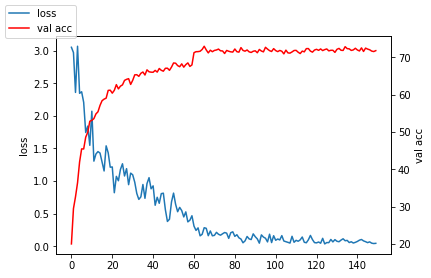

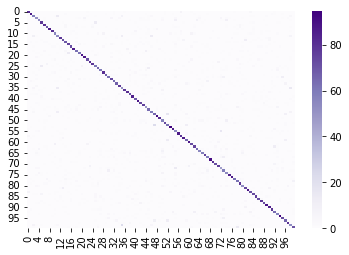

Accuracy of the model on the Test dataset:71.93%
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       100
           1       0.85      0.87      0.86       100
           2       0.59      0.58      0.59       100
           3       0.56      0.51      0.53       100
           4       0.57      0.54      0.55       100
           5       0.71      0.78      0.74       100
           6       0.79      0.81      0.80       100
           7       0.76      0.69      0.72       100
           8       0.87      0.86      0.86       100
           9       0.84      0.81      0.83       100
          10       0.62      0.56      0.59       100
          11       0.50      0.53      0.51       100
          12       0.79      0.78      0.78       100
          13       0.73      0.71      0.72       100
          14       0.63      0.69      0.66       100
          15       0.68      0.75      0.71       100
          16       0.74      0.7

71.93

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
#Create model
model=ResNet18(BuildingBlock)
#Number of training iterations
num_epochs=150
model.cuda()
#Learning rate
learning_rate=0.01
optimizer = torch.optim.SGD(model.parameters(),
                lr=learning_rate,
                momentum=0.9,
                weight_decay=0.0001,
                nesterov=True)

#Set the learning rate drop rule.
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [60,120],gamma=0.1)
#Set loss function
criterion= nn.CrossEntropyLoss().cuda()
train(model,num_epochs,train_loader,criterion,scheduler,optimizer,"group76_pretrained_model.h5")
eval(model, test_loader, "Test",True)


#  5 Test the model from pre-trained model
    Load the pre-trained model completed in the job and test the accuracy.

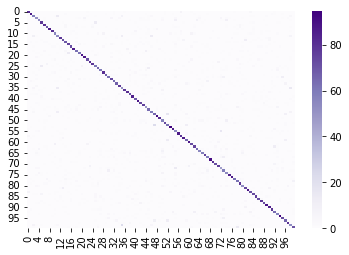

Accuracy of the model on the Test dataset:71.93%
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       100
           1       0.85      0.87      0.86       100
           2       0.59      0.58      0.59       100
           3       0.56      0.51      0.53       100
           4       0.57      0.54      0.55       100
           5       0.71      0.78      0.74       100
           6       0.79      0.81      0.80       100
           7       0.76      0.69      0.72       100
           8       0.87      0.86      0.86       100
           9       0.84      0.81      0.83       100
          10       0.62      0.56      0.59       100
          11       0.50      0.53      0.51       100
          12       0.79      0.78      0.78       100
          13       0.73      0.71      0.72       100
          14       0.63      0.69      0.66       100
          15       0.68      0.75      0.71       100
          16       0.74      0.7

71.93

In [14]:
model=torch.load(r"group76_pretrained_model.h5")
model.cuda()
eval(model, test_loader, "Test",True)